In [15]:
import numpy as np                   #Python  Array library
import pandas as pd                  #Excel library for python
import matplotlib.pyplot as plt      #Drawing library for python
import collections                  
import os
from sklearn.model_selection import ShuffleSplit

In [16]:
#!conda install -c conda-forge rdkit

In [17]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit import RDConfig
from rdkit.Chem.Fingerprints import ClusterMols, DbFpSupplier, MolSimilarity, SimilarityScreener
from rdkit.Chem.Fingerprints import FingerprintMols as fp
from rdkit.Chem import AllChem
from rdkit.Chem import rdmolops
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.utils.np_utils import to_categorical
from keras.wrappers.scikit_learn import KerasRegressor
from keras.regularizers import l1_l2, l2, l1
from keras.optimizers import Adam

In [19]:
ChemInputs = pd.read_csv('Lipophilicity.csv')
ChemInputs.head()

,CMPD_CHEMBLID,exp,smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...


In [20]:
ChemInputs['smiles'] = pd.Series(ChemInputs['smiles'], dtype="string") #스마일스 열의 원소가 Series 타입이다. string으로 바꾸라
type(ChemInputs['smiles'])

pandas.core.series.Series

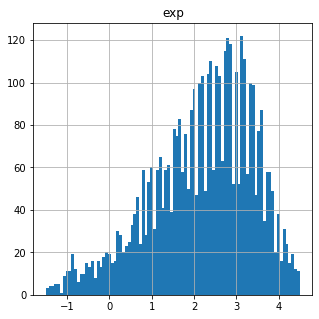

In [21]:
%matplotlib inline
ChemInputs.hist(bins=90,figsize=(5,5))
plt.show()

In [22]:
"""ID,SMILES,exp,InChi"""
ChemSMILES = ChemInputs.iloc[:,-1]
y = ChemInputs.iloc[:,1]

In [23]:
"""SMILES change to Fingerprint """
LEN_OF_FF = 2048


#for ChemSMILES in ChemSMILES:
#    mols = chem.MolFromSmiles(ChemSMILES)


mols = [Chem.MolFromSmiles(ChemSMILES) for ChemSMILES in ChemSMILES] #SMILES to Mol
fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=LEN_OF_FF) for m in mols] # Mol to Fingerprint

In [24]:
pin = len(fps)-1
print(f"{len(fps[pin]), fps[pin]}\n")
#fps[pin].ToBitString()


(2048, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x000001FA50D83120>)



In [25]:
x = []
for fp in fps:
    arr = np.zeros((1,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    x.append(arr)
x = np.asarray(x)
y = np.asarray(y)
print(x.shape, y.shape)

(4200, 2048) (4200,)


In [26]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

In [27]:
from tensorflow.keras import regularizers
from keras import models
from keras import layers

def build_model():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(
        units= 1024,
        kernel_initializer='glorot_uniform', 
        kernel_regularizer=regularizers.l2(1e-4),
        activation='relu',
        input_shape=(2048,)),
    tf.keras.layers.Dropout(0.01),
     tf.keras.layers.Dense(
        units= 256,
        kernel_regularizer=regularizers.l1(1e-4),
        activation='relu'),
    tf.keras.layers.Dropout(0.01),
    
    tf.keras.layers.Dense(
        units= 64,
        kernel_regularizer=regularizers.l2(1e-4),
        activation='relu'),
    tf.keras.layers.Dropout(0.01),
    tf.keras.layers.Dense(
        units= 8,
        kernel_regularizer=regularizers.l2(1e-4),
        activation='relu'),
    
    tf.keras.layers.Dense(units=1)])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [28]:

k =10

num_val_samples = len(x_train) //k
num_epochs = 100
all_scores = []
all_mae_histories = []
for i in range(k):
    print('처리 중인 폴드 #', i)
    val_data = x_train[i*num_val_samples: (i+1)*num_val_samples]
    val_targets = y_train[i*num_val_samples: (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate(
    [x_train[:i*num_val_samples], x_train[(i+1)*num_val_samples:]], axis =0)
    partial_train_targets = np.concatenate(
    [y_train[:i*num_val_samples], y_train[(i+1) * num_val_samples:]], axis =0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, validation_data = (val_data, val_targets), 
                       epochs = num_epochs, batch_size = 32, verbose = 0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

처리 중인 폴드 # 0
처리 중인 폴드 # 1
처리 중인 폴드 # 2
처리 중인 폴드 # 3
처리 중인 폴드 # 4
처리 중인 폴드 # 5
처리 중인 폴드 # 6
처리 중인 폴드 # 7
처리 중인 폴드 # 8
처리 중인 폴드 # 9


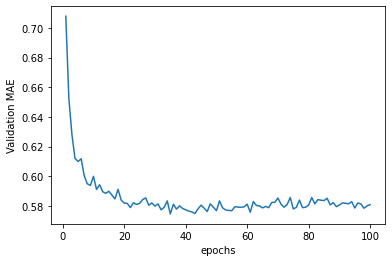

In [29]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('epochs')
plt.ylabel('Validation MAE')
plt.show()

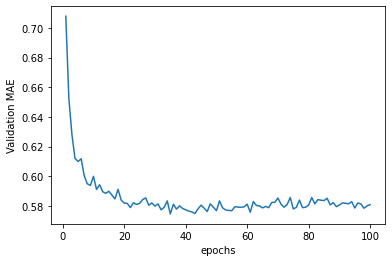

In [30]:
def smooth_curve(points, factor =0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point *(1 - factor))
        else:
            smoothed_points.append(point)
            
        return smoothed_points
    
smoothed_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('epochs')
plt.ylabel('Validation MAE')
plt.show()

In [ ]:
#에포크를 42로 잡겠다.

In [31]:
model = build_model()
model.fit(x_train, y_train, epochs = 42, batch_size = 32, verbose =0)


In [32]:
model.evaluate(x_test, y_test)

840/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.6354635323796953, 0.5607961]

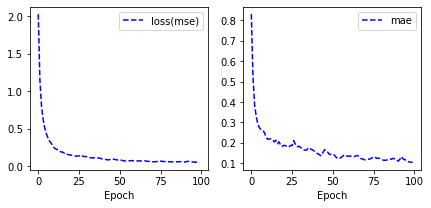

In [33]:
plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b--', label='loss(mse)')
#plt.plot(history.history['val_loss'], 'r--', label='val_loss(mse)')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], 'b--', label='mae')
#plt.plot(history.history['val_mae'], 'r--', label='val_mae')
plt.xlabel('Epoch')
plt.legend()
plt.show()

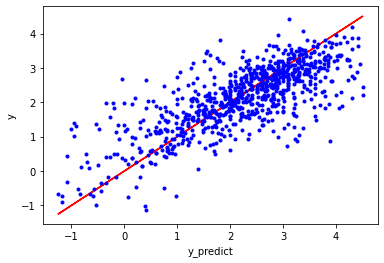

0.5649030934616084


In [34]:
from sklearn.metrics import r2_score

y_pred = model.predict(x_test)

plt.ylabel('y')
plt.xlabel('y_predict')
plt.plot(y_test,y_test,'r-')
plt.plot(y_test,y_pred,'b.')
plt.show()

r2 = r2_score(y_test, y_pred)
print(f"{r2}")

# 참 쉽죠?